In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Decadal variability of WMT in GFDL's OM4
JRA forcing  

In [6]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram
import gsw
import wmt_bgc.basic as wmt
import fastjmd95 as jmd95
%matplotlib inline

In [7]:
# Load the data
# (from restart)
rootdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/'
pp = 'ocean_annual_z'
localdir = '/ts/annual/5yr/'
filename = pp+'.201*.nc'
ds = xr.open_mfdataset(rootdir+pp+localdir+filename)
grid = xr.open_dataset(rootdir+pp+'/'+pp+'.static.nc')

In [8]:
# Specification for heat and salt budgets
variables = {'heat':'thetao','salt':'so'}
terms = {}
terms['heat']=['opottemptend','T_advection_xy','Th_tendency_vert_remap',
               'boundary_forcing_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
terms['salt']=['osalttend','S_advection_xy','Sh_tendency_vert_remap',
               'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']

In [9]:
# Preprocess
# Isolate Southern Ocean
ds_SO = ds.sel(yh=slice(-90,-30),yq=slice(-90,-30))

# Pressure from depth
ds_SO['p'] = wmt.gsw_p_from_z(-ds_SO['z_l'],grid['geolat'])

# Calculate density
density = 'mjd05'
if density=='sigma0':
    ### sigma0
    # Calculate density
    ds_SO['density'] = wmt.gsw_sigma0(ds_SO['so'],ds_SO['thetao'])
    # Calculate alpha and beta
    alpha = wmt.gsw_alpha(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = wmt.gsw_beta(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
elif density=='jmd95':
    ### jmd95
    # Calculate density
    ds_SO['density'] = jmd95.rho(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    # Calculate alpha and beta
    alpha = jmd95.drhodt(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = jmd95.drhods(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
elif density=='mjd05':
    ### mjd05
    # Calculate density
    ds_SO['density'] = wmt.sigmantr_mjd05(ds_SO['so'],ds_SO['thetao'])
    # Calculate alpha and beta
    alpha = wmt.gsw_alpha(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])
    beta = wmt.gsw_beta(ds_SO['so'],ds_SO['thetao'],ds_SO['p'])

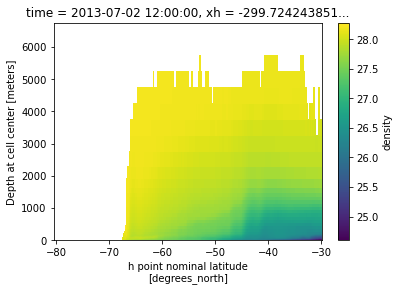

In [10]:
ds_SO['density'].isel(time=0,xh=0).plot()

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


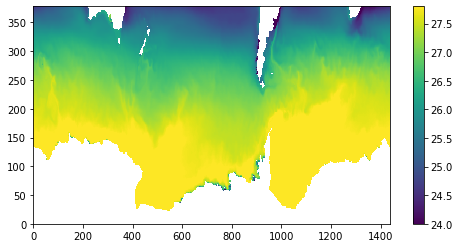

In [11]:
fig,ax=plt.subplots(figsize=(8,4))
im=ax.pcolormesh(ds_SO['density'].isel(z_l=0).mean('time'),vmin=24,vmax=27.8)
plt.colorbar(im,ax=ax)

In [12]:
# Calculate density tendency
densitytendency = wmt.densitytendency_from_heat_and_salt(ds_SO['boundary_forcing_heat_tendency'],
                              -ds_SO['boundary_forcing_salt_tendency'],
                              alpha=alpha,beta=beta)
dt = densitytendency.sum('z_l').mean('time').load()

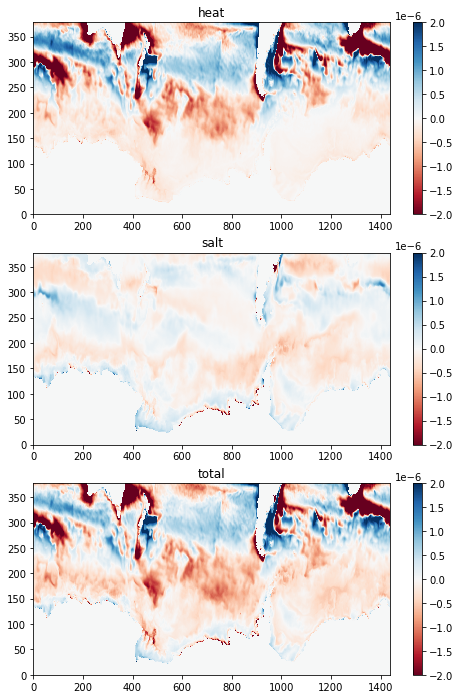

In [13]:
fig,ax=plt.subplots(figsize=(8,12),nrows=3)
a = 0
for term in dt.data_vars:
    axnow=ax[a]
    im=axnow.pcolormesh(dt[term],cmap='RdBu',vmin=-0.2E-5,vmax=0.2E-5)
    axnow.set_title(term)
    plt.colorbar(im,ax=axnow)
    a+=1

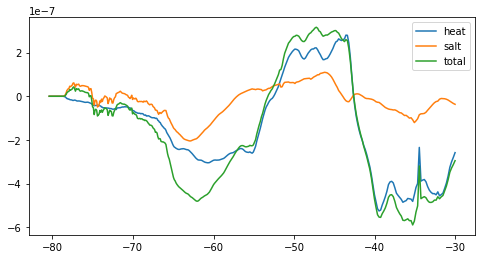

In [18]:
fig,ax=plt.subplots(figsize=(8,4))
for term in dt.data_vars:
    axnow=ax
    im=axnow.plot(dt['yh'],dt[term].mean('xh'),label=term)
ax.legend()

In [44]:
# Histogram boundary fluxes by density
sigma0_bins = np.arange(26,28.5,0.02)
mask = np.isnan(ds_SO['density'])
densitytendency_binned = xr.Dataset()
for term in densitytendency.data_vars:
    print(term)
    tendency = (densitytendency[term]*grid['areacello']).where(~mask)
    densitytendency_binned[term] = histogram(ds_SO['density'].where(~mask),
                            bins=[sigma0_bins],
                            dim=['xh','yh','z_l'],
                            weights=tendency)

heat
salt
total


In [45]:
densitytendency_binned.load();

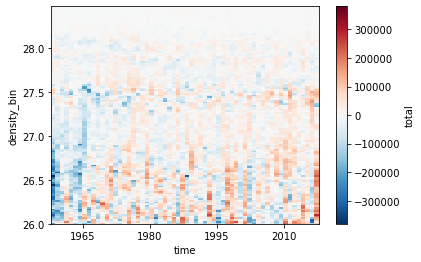

In [46]:
(densitytendency_binned['total']-densitytendency_binned['total'].mean('time')).transpose().plot()

In [47]:
# Calculate water mass transformation
rho0 = 1035.0
ddensity = xr.DataArray(np.diff(sigma0_bins),
                  dims=['density_bin'],
                  coords={'density_bin':densitytendency_binned['density_bin']})
G = xr.Dataset()
for term in densitytendency_binned.data_vars:
    print(term)
    G[term] = rho0*densitytendency_binned[term]/ddensity

heat
salt
total


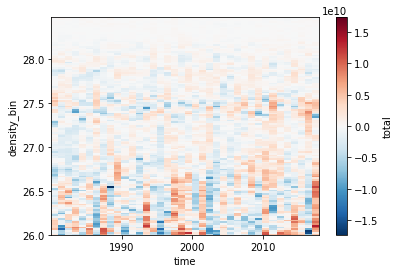

In [51]:
(G['total'].sel(time=slice('1980-01-01','2017-12-31'))-G['total'].sel(time=slice('1980-01-01','2017-12-31')).mean('time')).transpose().plot()

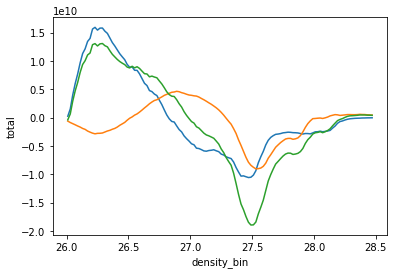

In [49]:
G['heat'].mean('time').plot()
G['salt'].mean('time').plot()
G['total'].mean('time').plot()

In [17]:
ds

<xarray.Dataset>
Dimensions:                         (nv: 2, time: 5, xh: 1440, xq: 1440, yh: 1080, yq: 1080, z_i: 36, z_l: 35)
Coordinates:
  * nv                              (nv) float64 1.0 2.0
  * time                            (time) object 2013-07-02 12:00:00 ... 201...
  * xh                              (xh) float64 -299.7 -299.5 ... 59.78 60.03
  * yh                              (yh) float64 -80.39 -80.31 ... 89.84 89.95
  * z_i                             (z_i) float64 0.0 5.0 ... 6.25e+03 6.75e+03
  * z_l                             (z_l) float64 2.5 10.0 ... 6e+03 6.5e+03
  * xq                              (xq) float64 -299.6 -299.3 ... 59.91 60.16
  * yq                              (yq) float64 -80.35 -80.27 ... 89.89 90.0
Data variables:
    Kd_BBL                          (time, z_i, yh, xh) float32 dask.array<chunksize=(5, 36, 1080, 1440), meta=np.ndarray>
    average_DT                      (time) timedelta64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    average_T1                      (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    average_T2                      (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    time_bnds                       (time, nv) timedelta64[ns] dask.array<chunksize=(5, 2), meta=np.ndarray>
    Kd_ePBL                         (time, z_i, yh, xh) float32 dask.array<chunksize=(5, 36, 1080, 1440), meta=np.ndarray>
    Kd_interface                    (time, z_i, yh, xh) float32 dask.array<chunksize=(5, 36, 1080, 1440), meta=np.ndarray>
    Kd_itides                       (time, z_i, yh, xh) float32 dask.array<chunksize=(5, 36, 1080, 1440), meta=np.ndarray>
    Kd_shear                        (time, z_i, yh, xh) float32 dask.array<chunksize=(5, 36, 1080, 1440), meta=np.ndarray>
    S_advection_xy                  (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    S_adx                           (time, z_l, yh, xq) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    S_ady                           (time, z_l, yq, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    Sh_tendency_vert_remap          (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    T_advection_xy                  (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    T_adx                           (time, z_l, yh, xq) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    T_ady                           (time, z_l, yq, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    Th_tendency_vert_remap          (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    agessc                          (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    boundary_forcing_heat_tendency  (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    boundary_forcing_salt_tendency  (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    difmxybo                        (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    difvho                          (time, z_i, yh, xh) float32 dask.array<chunksize=(5, 36, 1080, 1440), meta=np.ndarray>
    difvso                          (time, z_i, yh, xh) float32 dask.array<chunksize=(5, 36, 1080, 1440), meta=np.ndarray>
    frazil_heat_tendency            (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    obvfsq                          (time, z_i, yh, xh) float32 dask.array<chunksize=(5, 36, 1080, 1440), meta=np.ndarray>
    opottempdiff                    (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=np.ndarray>
    opottemptend                    (time, z_l, yh, xh) float32 dask.array<chunksize=(5, 35, 1080, 1440), meta=